In [16]:
# Load your flattened dataset
import pandas as pd

df_flat = pd.read_csv("data/beyondblue_data_flattened.csv")
df_flat['text'] = df_flat['text'].astype(str).fillna("")
df_flat.head()

,parent_post_id,user_id,role,text,date,category
0,1,Toby,original,"Hello everyone, this is my first post, so I ho...",2025-07-16,Anxiety
1,1,Morph,commenter,"Hi Toby, welcome and congratulations on your f...",2025-07-17,Anxiety
2,1,AudaciousPoodle,commenter,"Hi Toby, Reading your post sounds just like wh...",2025-07-17,Anxiety
3,1,_Gigi_,commenter,"Hello Toby,I'm glad you've decided to reach ou...",2025-07-18,Anxiety
4,1,Toby,op_reply,My anxiety is affecting my whole life. When I ...,2025-07-18,Anxiety


In [17]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sentiment model (NEGATIVE / NEUTRAL / POSITIVE)
sent_tok = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", use_fast=True)
sent_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest").to(device)
sent_labels = ["NEGATIVE", "NEUTRAL", "POSITIVE"]

# Emotion model (ANGER, DISGUST, FEAR, JOY, NEUTRAL, SADNESS, SURPRISE)
emo_tok = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base", use_fast=True)
emo_model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base").to(device)
emo_labels = ["anger","disgust","fear","joy","neutral","sadness","surprise"]

/opt/miniconda3/envs/resproj/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassif

In [18]:
from torch.nn.functional import softmax

def predict_dist(texts, tokenizer, model, labels, batch_size=16, max_length=512):
    all_probs = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            ).to(device)
            logits = model(**enc).logits
            probs = softmax(logits, dim=-1).cpu().numpy()
            for p in probs:
                all_probs.append({lab: float(p[j]) for j, lab in enumerate(labels)})
    return all_probs

In [19]:
# texts = df_flat["text"].astype(str).fillna("").tolist()

# sent_dists = predict_dist(texts, sent_tok, sent_model, sent_labels, batch_size=16)
# emo_dists  = predict_dist(texts, emo_tok,  emo_model,  emo_labels,  batch_size=16)

In [20]:
# import numpy as np

# def valence_from_sentiment(dist):
#     return dist.get("POSITIVE", 0) - dist.get("NEGATIVE", 0)

# emo_to_va = {
#     "joy": {"val": 0.8, "aro": 0.6},
#     "surprise": {"val": 0.2, "aro": 0.7},
#     "neutral": {"val": 0.0, "aro": 0.4},
#     "sadness": {"val": -0.7, "aro": 0.3},
#     "fear": {"val": -0.7, "aro": 0.8},
#     "anger": {"val": -0.7, "aro": 0.8},
#     "disgust": {"val": -0.6, "aro": 0.7},
# }

# def va_from_emotion_dist(dist):
#     if not dist: return 0.0, 0.5
#     v=a=tot=0
#     for emo, p in dist.items():
#         if emo in emo_to_va:
#             v += emo_to_va[emo]["val"] * p
#             a += emo_to_va[emo]["aro"] * p
#             tot += p
#     if tot>0: v/=tot; a/=tot
#     return float(v), float(a)

# # sentiment
# df_flat["sentiment_dist"] = sent_dists
# df_flat["valence_s"] = [valence_from_sentiment(d) for d in sent_dists]
# df_flat["sentiment_top"] = [max(d, key=d.get) if d else None for d in sent_dists]
# df_flat["sentiment_conf"] = [max(d.values()) if d else np.nan for d in sent_dists]

# # emotion
# df_flat["emotion_dist"] = emo_dists
# va_pairs = [va_from_emotion_dist(d) for d in emo_dists]
# df_flat["valence_e"], df_flat["arousal_e"] = zip(*va_pairs)
# df_flat["emotion_top"] = [max(d, key=d.get) if d else None for d in emo_dists]
# df_flat["emotion_conf"] = [max(d.values()) if d else np.nan for d in emo_dists]

In [21]:
# df_flat.to_csv("data/beyondblue_data_flattened_transformers_enriched.csv", index=False)
# print("✅ saved enriched dataset with sentiment+emotion features")

In [22]:
import pandas as pd

# Load enriched dataset
df_transformed = pd.read_csv("data/beyondblue_data_flattened_transformers_enriched.csv")

# Convert date column
df_transformed["date"] = pd.to_datetime(df_transformed["date"], errors="coerce")

# Quick check
print(df_transformed.shape)
print(df_transformed.columns)
df_transformed.head(3)

(42961, 15)
Index(['parent_post_id', 'user_id', 'role', 'text', 'date', 'category',
       'sentiment_dist', 'valence_s', 'sentiment_top', 'sentiment_conf',
       'emotion_dist', 'valence_e', 'arousal_e', 'emotion_top',
       'emotion_conf'],
      dtype='object')


,parent_post_id,user_id,role,text,date,category,sentiment_dist,valence_s,sentiment_top,sentiment_conf,emotion_dist,valence_e,arousal_e,emotion_top,emotion_conf
0,1,Toby,original,"Hello everyone, this is my first post, so I ho...",2025-07-16,Anxiety,"{'NEGATIVE': 0.3422255218029022, 'NEUTRAL': 0....",-0.150841,NEUTRAL,0.466390,"{'anger': 0.0007661550189368427, 'disgust': 0....",-0.696869,0.798454,fear,0.994493
1,1,Morph,commenter,"Hi Toby, welcome and congratulations on your f...",2025-07-17,Anxiety,"{'NEGATIVE': 0.002651855116710067, 'NEUTRAL': ...",0.971309,POSITIVE,0.973961,"{'anger': 0.00208498677238822, 'disgust': 0.00...",0.650229,0.577532,joy,0.817238
2,1,AudaciousPoodle,commenter,"Hi Toby, Reading your post sounds just like wh...",2025-07-17,Anxiety,"{'NEGATIVE': 0.7963150143623352, 'NEUTRAL': 0....",-0.754034,NEGATIVE,0.796315,"{'anger': 0.0018220427446067333, 'disgust': 0....",-0.690610,0.312198,sadness,0.969912


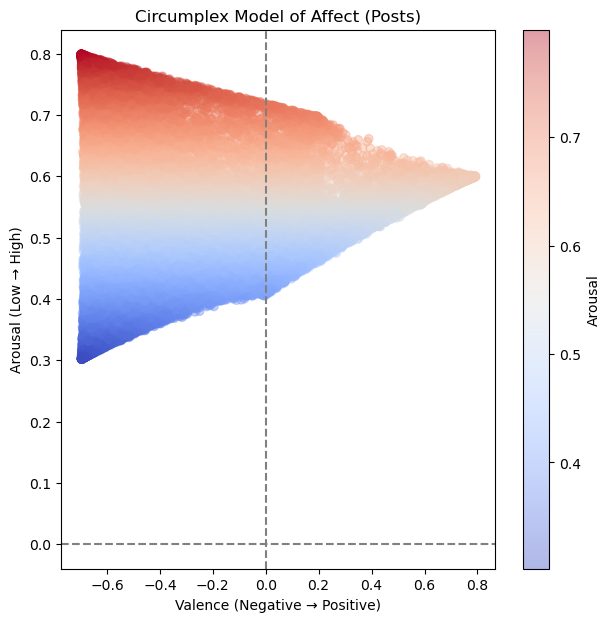

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
sc = plt.scatter(
    df_transformed["valence_e"], df_transformed["arousal_e"],
    c=df_transformed["arousal_e"], cmap="coolwarm", alpha=0.4
)
plt.colorbar(sc, label="Arousal")
plt.axhline(0, color="grey", linestyle="--")
plt.axvline(0, color="grey", linestyle="--")
plt.title("Circumplex Model of Affect (Posts)")
plt.xlabel("Valence (Negative → Positive)")
plt.ylabel("Arousal (Low → High)")
plt.show()

/var/folders/jm/36rrr53s1w388ms7208drrcm0000gn/T/ipykernel_30052/4162665840.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="emotion_top", data=df_transformed,


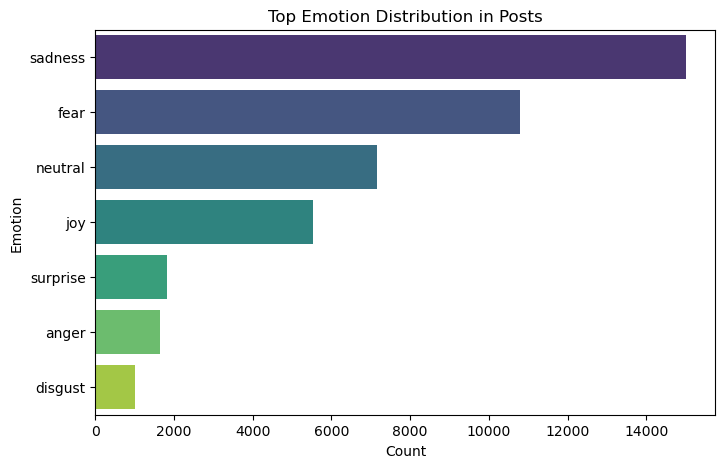

In [24]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(y="emotion_top", data=df_transformed,
              order=df_transformed["emotion_top"].value_counts().index,
              palette="viridis")
plt.title("Top Emotion Distribution in Posts")
plt.xlabel("Count")
plt.ylabel("Emotion")
plt.show()

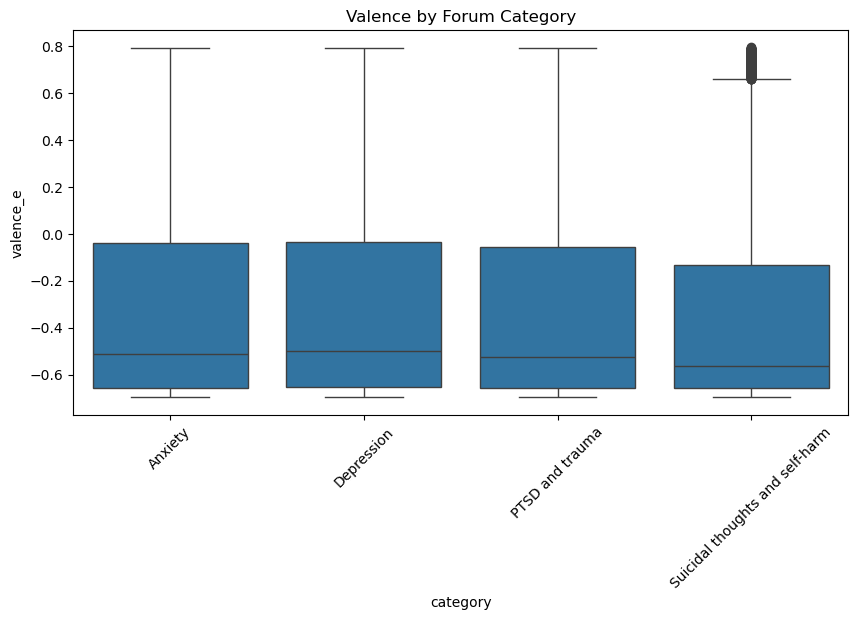

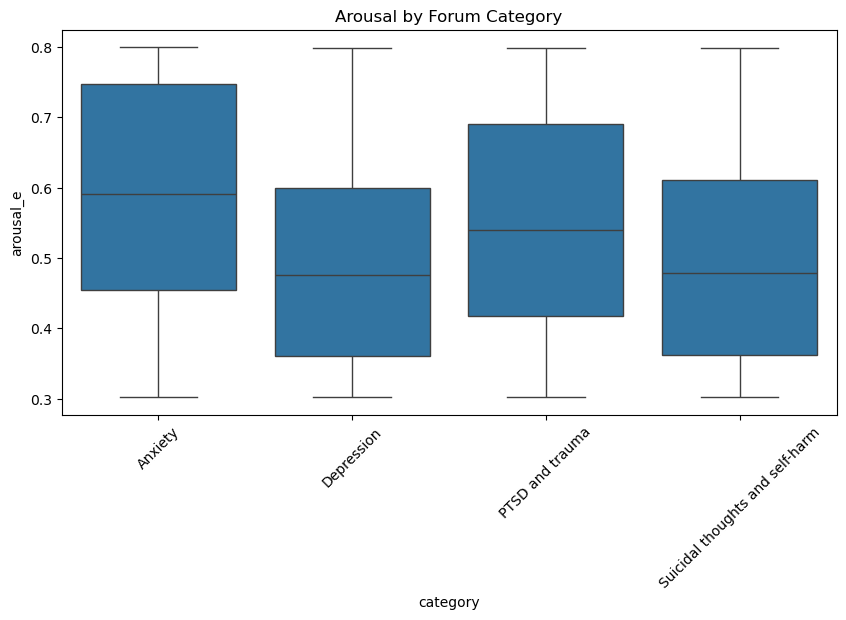

In [25]:
plt.figure(figsize=(10,5))
sns.boxplot(x="category", y="valence_e", data=df_transformed)
plt.xticks(rotation=45)
plt.title("Valence by Forum Category")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x="category", y="arousal_e", data=df_transformed)
plt.xticks(rotation=45)
plt.title("Arousal by Forum Category")
plt.show()

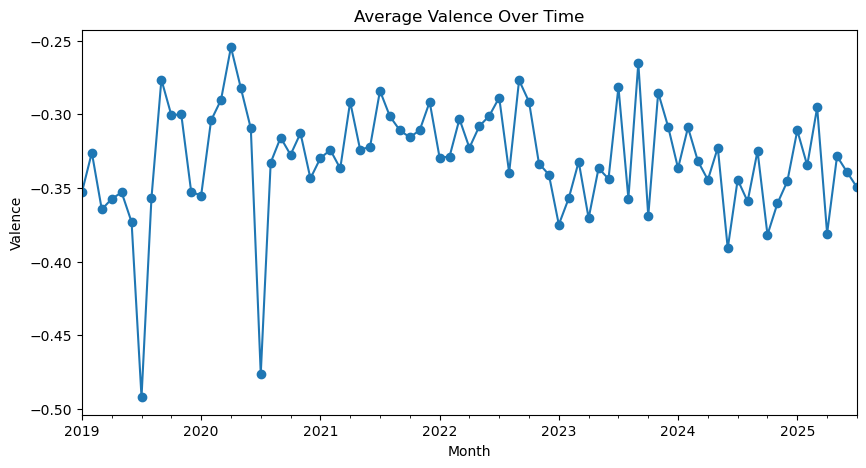

In [27]:
trend = df_transformed.groupby(pd.Grouper(key="date", freq="ME"))["valence_e"].mean()

plt.figure(figsize=(10,5))
trend.plot(marker="o")
plt.title("Average Valence Over Time")
plt.ylabel("Valence")
plt.xlabel("Month")
plt.show()

/var/folders/jm/36rrr53s1w388ms7208drrcm0000gn/T/ipykernel_30052/3462446763.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="role", y="valence_e", data=df_transformed, palette="Set2")


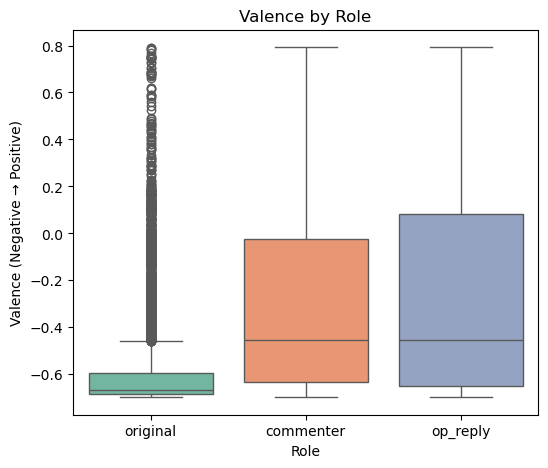

/var/folders/jm/36rrr53s1w388ms7208drrcm0000gn/T/ipykernel_30052/3462446763.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="role", y="arousal_e", data=df_transformed, palette="Set2")


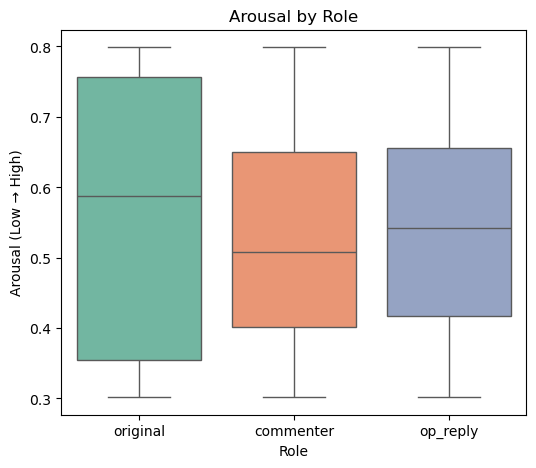

In [28]:
plt.figure(figsize=(6,5))
sns.boxplot(x="role", y="valence_e", data=df_transformed, palette="Set2")
plt.title("Valence by Role")
plt.ylabel("Valence (Negative → Positive)")
plt.xlabel("Role")
plt.show()

plt.figure(figsize=(6,5))
sns.boxplot(x="role", y="arousal_e", data=df_transformed, palette="Set2")
plt.title("Arousal by Role")
plt.ylabel("Arousal (Low → High)")
plt.xlabel("Role")
plt.show()

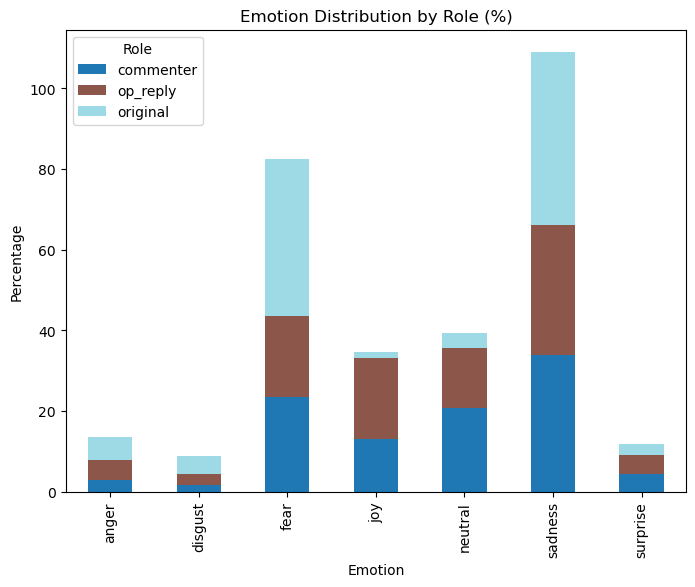

In [29]:
role_emotions = df_transformed.groupby(["role", "emotion_top"]).size().unstack(fill_value=0)

role_emotions_pct = role_emotions.div(role_emotions.sum(axis=1), axis=0) * 100
role_emotions_pct.T.plot(kind="bar", figsize=(8,6), stacked=True, colormap="tab20")
plt.title("Emotion Distribution by Role (%)")
plt.ylabel("Percentage")
plt.xlabel("Emotion")
plt.legend(title="Role")
plt.show()

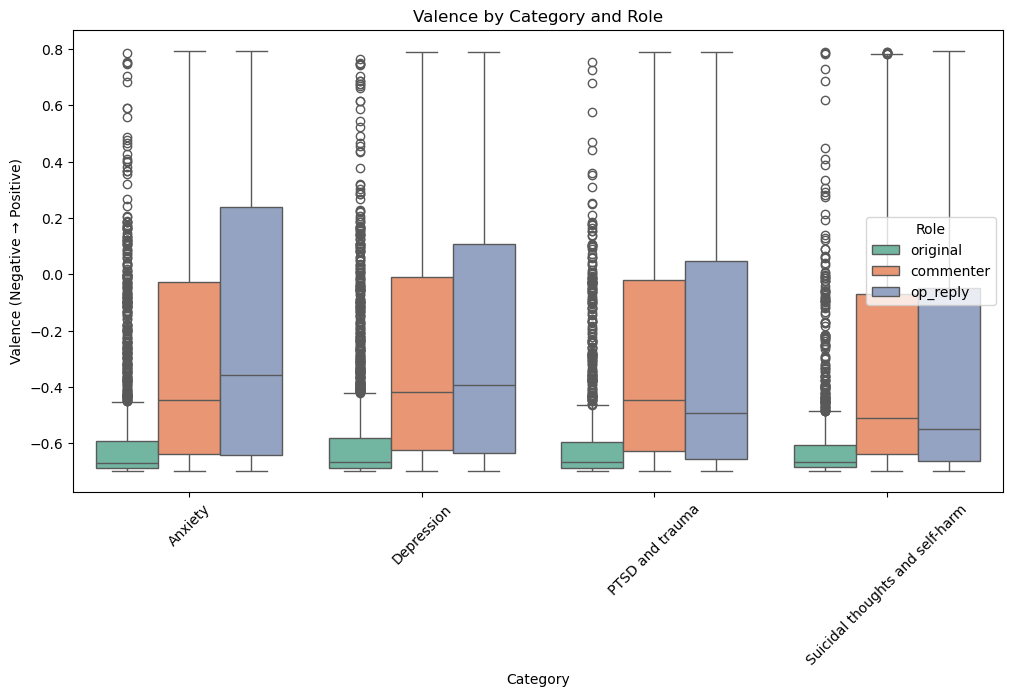

In [30]:
plt.figure(figsize=(12,6))
sns.boxplot(x="category", y="valence_e", hue="role", data=df_transformed, palette="Set2")
plt.xticks(rotation=45)
plt.title("Valence by Category and Role")
plt.ylabel("Valence (Negative → Positive)")
plt.xlabel("Category")
plt.legend(title="Role")
plt.show()

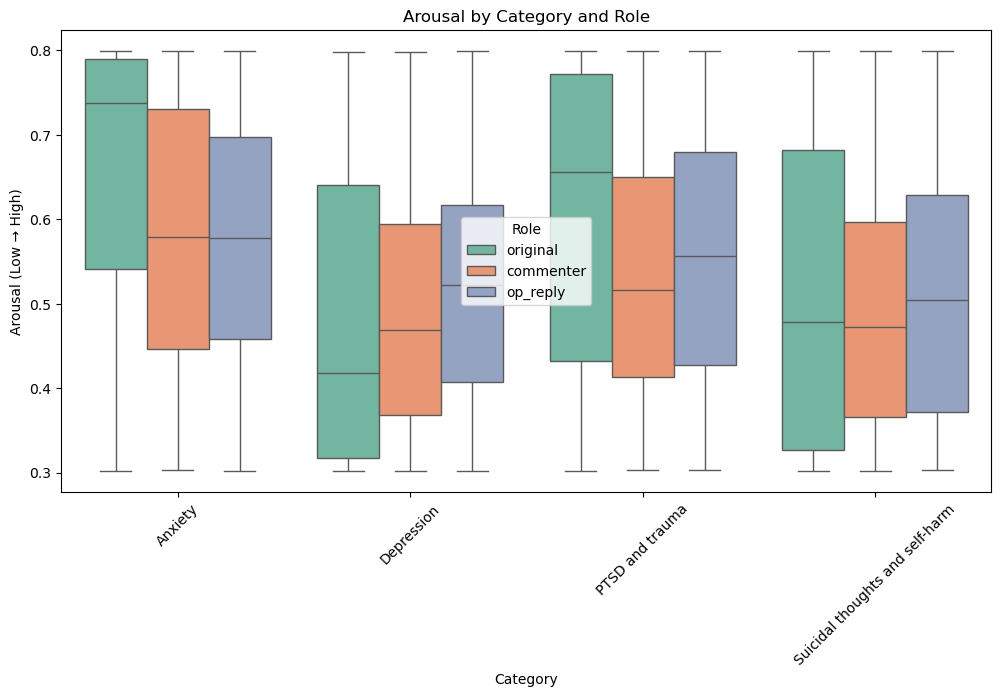

In [31]:
plt.figure(figsize=(12,6))
sns.boxplot(x="category", y="arousal_e", hue="role", data=df_transformed, palette="Set2")
plt.xticks(rotation=45)
plt.title("Arousal by Category and Role")
plt.ylabel("Arousal (Low → High)")
plt.xlabel("Category")
plt.legend(title="Role")
plt.show()